In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## Steps
- Read and understand the data
- Clean the data
- Prepare the data and add computed features (if required)
- Create the models

# 1. Load file and understand the features

In [2]:
df = pd.read_csv('Online+Retail.csv', encoding='ISO-8859-1', sep=',', header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [6]:
round((df.isnull().sum() / len(df)) * 100, 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

## 2. Clean the data

In [7]:
df = df.drop('Description',axis=1)

In [8]:
df = df.dropna(axis=0)

In [9]:
print(df.shape)
round((df.isnull().sum() / len(df)) * 100, 2)

(406829, 7)


InvoiceNo      0.0
StockCode      0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

### Observations:
- Around 24% of customerID is null - Drop these rows
- We will not use the description, so we will drop the column itself
- Order amount can be calculated as UnitPrice * Quantity
- Recency can be calculated by get number of days since last order for each customer
- Frequency we can get by counting the invoice number for each customer

### Compute the amount spent on the product

In [10]:
df['price'] = df['UnitPrice'] * df['Quantity']

In [11]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price
0,536365,85123A,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [13]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Compute the recency of buy by the customer

In [14]:
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
df['last_since'] = (max_date - df['InvoiceDate']).dt.days

In [16]:
df.nunique()

InvoiceNo      22190
StockCode       3684
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
price           4041
last_since       360
dtype: int64

In [17]:
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price,last_since
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373


### Observations:
- 

## 3. Prepare the data and add computed features (if required)

In [18]:
grouped_df = df.groupby('CustomerID')['price'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,price
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [19]:
grouped_frequency_df = df.groupby('CustomerID')['InvoiceNo'].count()
grouped_frequency_df = grouped_frequency_df.reset_index()
grouped_frequency_df.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [20]:
grouped_df = pd.merge(grouped_df, grouped_frequency_df, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,price,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [21]:
grouped_price = df.groupby('CustomerID')['last_since'].min()
grouped_price = grouped_price.reset_index()
grouped_price

,CustomerID,last_since
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
4367,18280.0,277
4368,18281.0,180
4369,18282.0,7
4370,18283.0,3


In [22]:
grouped_df = pd.merge(grouped_df, grouped_price, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,price,InvoiceNo,last_since
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [23]:
grouped_df.shape

(4372, 4)

### Treat the outliers on this df

In [24]:
def detect_outliers(df, column, ll, ul):
    q1 = df[column].quantile(ll)
    q3 = df[column].quantile(ul)
    
    iqr = q3 - q1
    threshold = 1.5 * iqr
    
    
    outliers = df[((df[column] < q1 - threshold) | (df[column] > q3 + threshold))]
    return outliers

In [25]:
def remove_outliers(df, column, ll, ul):
    q1 = df[column].quantile(ll)
    q3 = df[column].quantile(ul)
    
    iqr = q3 - q1
    threshold = 1.5 * iqr
    
    
    outliers = df[((df[column] < q1 - threshold) | (df[column] > q3 + threshold))]
    outliers = df[~df.isin(outliers)].dropna()
    return outliers

In [26]:
grouped_df = remove_outliers(grouped_df, 'price', 0.25, 0.75)
grouped_df.shape

(3949, 4)

In [27]:
grouped_df = remove_outliers(grouped_df, 'InvoiceNo', 0.25, 0.75)
grouped_df.shape

(3697, 4)

In [28]:
grouped_df = remove_outliers(grouped_df, 'last_since', 0.25, 0.75)
grouped_df.shape

(3697, 4)

### Rescale the data

In [29]:
rfm_df = grouped_df[['price', 'InvoiceNo', 'last_since']]
scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3697, 3)

## 4. Create the models

### Finding the optimal number of clusters

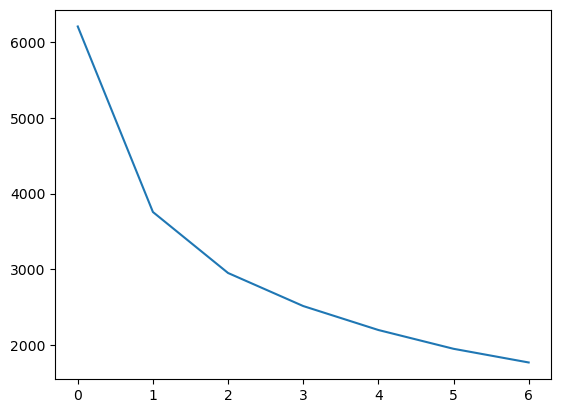

In [30]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)

In [31]:
range_n_clusters = [2,3,4,5,6,7,8]
for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print(f'For cluster {n} the silhoutte score is {silhouette_avg}')

For cluster 2 the silhoutte score is 0.4292946797663935
For cluster 3 the silhoutte score is 0.4399139359628542
For cluster 4 the silhoutte score is 0.40869010982184345
For cluster 5 the silhoutte score is 0.38828922948076383
For cluster 6 the silhoutte score is 0.3566046809662975
For cluster 7 the silhoutte score is 0.3321831338167751
For cluster 8 the silhoutte score is 0.34115209918940537


### Observation:
- 4 cluster formation will be best

In [32]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

### Assign the clusterId to the dataframe

In [33]:
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,price,InvoiceNo,last_since,cluster_id
0,12346.0,0.00,2.0,325.0,0
2,12348.0,1797.24,31.0,74.0,1
3,12349.0,1757.55,73.0,18.0,2
4,12350.0,334.40,17.0,309.0,0
5,12352.0,1545.41,95.0,35.0,2


### Analyse the relationship and behaviour of each cluster

#### Price Cluster - Monetary

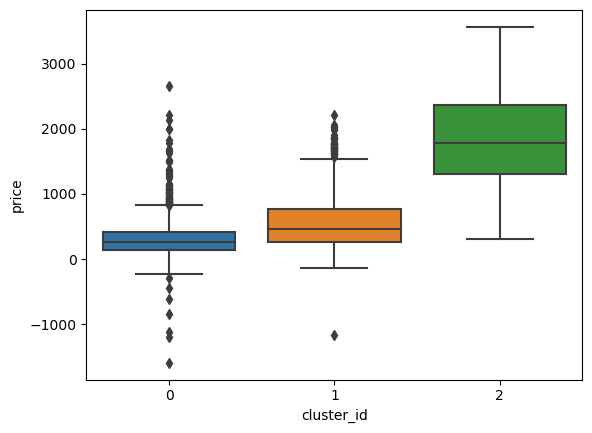

In [34]:
sns.boxplot(data=grouped_df, x='cluster_id', y='price')
plt.show()

#### InvoiceNo cluster - Frequency

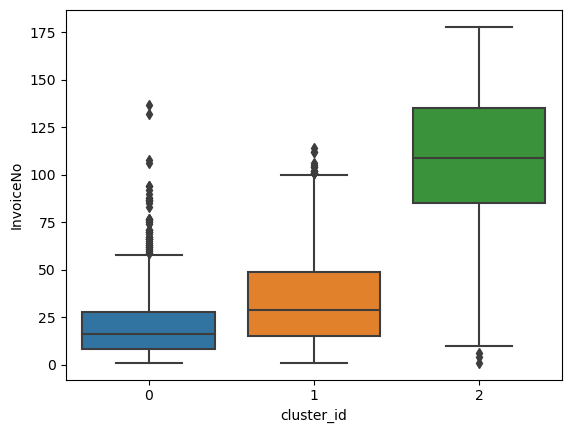

In [35]:
sns.boxplot(data=grouped_df, x='cluster_id', y='InvoiceNo')
plt.show()

#### LastSince cluster - Recency

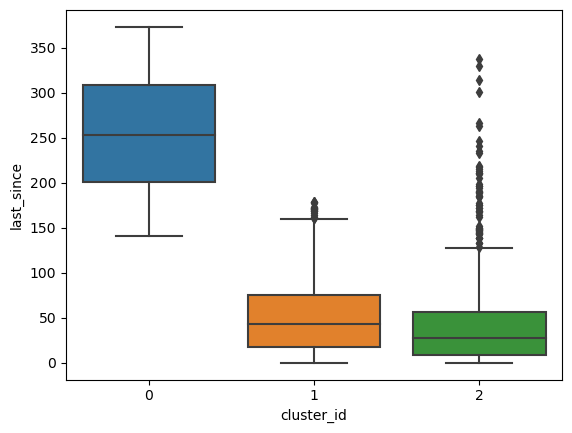

In [36]:
sns.boxplot(data=grouped_df, x='cluster_id', y='last_since')
plt.show()

--------------------------------

In [7]:
arr1 = np.array([[2,1,1], [3,2,1], [2,1,2]])
arr1

array([[2, 1, 1],
       [3, 2, 1],
       [2, 1, 2]])

In [6]:
arr1_inv = np.linalg.inv(arr1)
arr1_inv

array([[ 3., -1., -1.],
       [-4.,  2.,  1.],
       [-1.,  0.,  1.]])